## Create a model using bigML pipelines. 
A Waylay query is exported as csv and is used as input to the bigML pipeline. The data used in this notebook is data used in this notebook: https://github.com/waylayio/demo-general/blob/master/byoml/tutorial.ipynb. We then upload the model to byoml and perform a prediction.

First we read in the csv and use the last sample as test sample.

In [1]:
import csv
import os
import json
import pandas as pd
import numpy as np
import matplotlib as plt

from bigml.api import BigML
from bigml.anomaly import Anomaly


In [2]:
csv_path = 'waylay_data_export.csv'
df = pd.read_csv(csv_path)
df = df.loc[:, ['temperature', 'light-ambience']]

df.describe()

,temperature,light-ambience
count,1680.000000,1680.000000
mean,18.623020,638.395419
std,2.302896,532.613071
min,13.020909,0.000000
25%,16.672486,0.000000
50%,18.861395,628.764247
75%,20.712567,1124.747130
max,23.793903,1964.023804


In [3]:
df.head()

,temperature,light-ambience
0,17.476471,648.370531
1,18.861175,1217.957350
2,20.798265,998.371057
3,18.857261,808.531495
4,16.074553,0.000000


<AxesSubplot:xlabel='temperature', ylabel='light-ambience'>

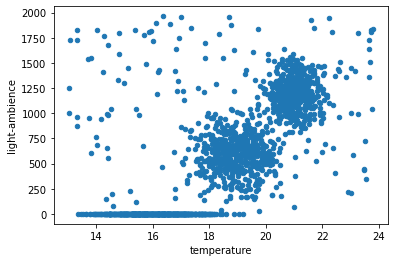

In [4]:
df.plot.scatter(x='temperature', y='light-ambience')

We create a bigML object using our API key which is set in the environment variables:

BIGML_USERNAME: \<your_bigML_username\>

BIGML_API_KEY: \<your_bigML_api_key\>

In [5]:
api = BigML()

source = api.create_source(csv_path)
api.ok(source)
dataset = api.create_dataset(source, {'excluded_fields': ['timestamp']})
api.ok(dataset)
model = api.create_anomaly(
    dataset,
    {
        'top_n': 150
    }
)

api.ok(model)

True

When we create an anomaly prediction, an anomaly score is returned with 0 being no anomaly and 1 being an anomaly. This means that every value between [0, 0.5] is predicted as not an anomaly while values between [0.5, 1] are predicted as being an anomaly. 

Input data to the model should be an object with column names equal to the ones on which the model has been trained. The cells below shows that entering different field names yields different results.

In [6]:
api.create_anomaly_score(model, [[0, 0]])

Validation error: {'input_data': 'Must be an object'}
Double-check the arguments for the call, please.


2021-08-05 17:58:54,245: Validation error: {'input_data': 'Must be an object'}
Double-check the arguments for the call, please.


{'code': 400,
 'resource': None,
 'location': None,
 'object': None,
 'error': {'code': 400,
  'status': {'code': -1206,
   'extra': {'input_data': 'Must be an object'},
   'message': 'Validation error'}}}

In [7]:
api.create_anomaly_score(model, {"feature_1": 24, "feature_2": 2000})['object']['score']

0.94814

In [8]:
api.create_anomaly_score(model, {"light-ambience": 2000, "temperature": 24})['object']['score']

0.70391

In [9]:
# Anomaly
prediction = api.create_anomaly_score(model, {"temperature": 24, "light-ambience": 2000})
prediction['object']['score']

0.70391

In [10]:
# Anomaly
prediction = api.create_anomaly_score(model, {"temperature": 21, "light-ambience": 0})
prediction['object']['score']

0.62808

In [11]:
# No anomaly
prediction = api.create_anomaly_score(model, {"temperature": 17, "light-ambience": 0})
prediction['object']['score']

0.4241

In [12]:
# No anomaly
prediction = api.create_anomaly_score(model, {"temperature": 21, "light-ambience": 1250})
prediction['object']['score']

0.36618

In [13]:
# No anomaly
prediction = api.create_anomaly_score(model, {"temperature": 19, "light-ambience": 500})
prediction['object']['score']

0.39432

The anomaly predictor can also be run locally. By running the next 3 cells, a local 'storage'-folder will be created which will store the local model to run the predictions. The anomaly name can be found in the BigML dashboard.

In [14]:
# To predict scores fill the desired input_data
# in next line. Numeric fields are compulsory.
input_data = {
    "light-ambience": 500,
    "temperature": 19
}

In [15]:
# Test the anomaly model created through dashboard with the same configuration parameters as this notebook
anomaly = Anomaly('anomaly/60d9b7549193b91734001e88',
                  api=BigML()
                 )

anomaly.anomaly_score(input_data)
# The result is a float number which value is between 0 and 1.

0.39432123575264455

Or use the BigML API directly to create an anomaly model.

In [16]:
anomaly_name = prediction['object']['anomaly']

In [17]:
local_anomaly = api.get_anomaly(anomaly_name, query_string='limit=-1')
type(local_anomaly)

dict

In [18]:
local_anomaly_model = Anomaly(local_anomaly)
type(local_anomaly_model)

bigml.anomaly.Anomaly

We will create a wrapper around the bigML model, which will enable us to upload the model to byoml and make predictions with it. We suppose that input_data is a numpy ndarray for now, until a separate BigML docker image has been deployed. 

In [19]:
class BigMLModel:
    def __init__(self, model, column_names):
        self.model = model
        self.column_names = list(column_names)

    def predict(self, input_data):
        input_df = pd.DataFrame(input_data, columns=self.column_names)
        json_input = json.loads(input_df.to_json(orient='records'))[0]
        return np.array(self.model.anomaly_score(json_input))


In [20]:
np_input_data = np.array(list(input_data.values())).reshape(1, 2)
model_to_upload = BigMLModel(anomaly, input_data.keys()) # local_anomaly_model can also be used instead of anomaly
model_to_upload.predict(np_input_data)

array(0.39432124)

In [21]:
from waylay import WaylayClient, RestResponseError
waylay = WaylayClient.from_profile('staging')
waylay.byoml.set_root_url('https://byoml-openfaas-staging.waylay.io')
waylay.byoml.root_url

'https://byoml-openfaas-staging.waylay.io'

In [22]:
MODEL_NAME = 'bigml-model'
try:
    waylay.byoml.model.remove(MODEL_NAME)
except RestResponseError as e:
    display(f'Ignored: {e}')

"Ignored: ByomlActionError(404: 'Model does not exist'; DELETE 'https://byoml-openfaas-staging.waylay.io/models/bigml-model')"

In order to deploy our created model, we will need to pickle the model using the dill library. We will also need to include the bigml library into a requirements.txt file in the upload folder.

In [23]:
import dill
from zipfile import ZipFile
import tempfile
from pathlib import Path
from time import sleep

is_not_ready = True

def upload_model(model_name, model_object):
    with tempfile.TemporaryDirectory() as temp_dir:
        model_path = Path(temp_dir, 'model.joblib')
        requirements_file_name = 'requirements.txt'

        with open(Path(temp_dir, requirements_file_name), 'wt') as outf:
            outf.write('bigml')

        with open(model_path, 'wb') as model_file:
            dill.settings['recurse'] = True
            dill.dump(model_object, model_file)

        return waylay.byoml.model.upload(
            model_name=model_name,
            trained_model=temp_dir, 
            framework='sklearn', 
            description='BigML model example'
        )
    
def wait_until_ready(model_name):
    while is_not_ready:
        result = waylay.byoml.model.get(MODEL_NAME)
        if result.get('ready'):
             return result
        print('Still waiting on model to be deployed')
        sleep(5)

We will upload the model and create a prediction using numpy arrays as input. When we create a separate BigML docker image, it will be possible to use the serialisation from BigML, i.e. feed objects as input.

In [24]:
print(upload_model(MODEL_NAME, model_to_upload))
wait_until_ready(MODEL_NAME)

{'author': 'users/f0981778-feed-4d08-823e-dc65e2b8a502', 'createdBy': 'users/f0981778-feed-4d08-823e-dc65e2b8a502', 'createdOn': '2021-08-05T16:00:59.559542+00:00', 'description': 'BigML model example', 'framework': 'sklearn', 'framework_version': '0.22', 'message': 'Model successfully uploaded', 'name': 'bigml-model', 'updatedOn': '2021-08-05T16:00:59.559595+00:00', 'version': '1'}
Still waiting on model to be deployed
Still waiting on model to be deployed
Still waiting on model to be deployed
Still waiting on model to be deployed
Still waiting on model to be deployed
Still waiting on model to be deployed
Still waiting on model to be deployed
Still waiting on model to be deployed
Still waiting on model to be deployed
Still waiting on model to be deployed
Still waiting on model to be deployed


{'createdBy': 'users/f0981778-feed-4d08-823e-dc65e2b8a502',
 'createdOn': '2021-08-05T16:00:59.424000+00:00',
 'description': 'BigML model example',
 'framework': 'sklearn',
 'framework_version': '0.22',
 'name': 'bigml-model',
 'ready': True,
 'supported_endpoints': ['predict'],
 'updatedBy': 'users/f0981778-feed-4d08-823e-dc65e2b8a502',
 'updatedOn': '2021-08-05T16:00:59.424000+00:00',
 'version': '1'}

In [25]:
byoml_prediction = waylay.byoml.model.predict(MODEL_NAME, np_input_data)
byoml_prediction

array(0.39432124)

In [26]:
waylay.byoml.model.remove(MODEL_NAME)

{'message': 'Model successfully deleted', 'name': 'bigml-model'}